# Workbook on Biomedical Imaging extraction
This workbook will have you practice some of the methods that we introduced in the demonstration notebook. For each step, you will find instructions for what to do followed by an empty code cell to enter your work. Don't forget that you will need to import the appropriate packages for this work.

The demonstration notebook showed you how to do a lot of these tasks within Python. However, if you would like to try out different command lines or include screenshots from your viewer, then we can show you how to include those into your answer.

In [7]:
%%capture --no-display 
%matplotlib inline
import os
import nibabel as nb
import numpy as np
from niwidgets import NiftiWidget
import pandas as pd
import ants
import matplotlib.pyplot as plt


In [8]:
def write_image(image_to_write,rootdir,subject,image_type,image_desc,image_space=None):
    if image_space is not None:
        image_name = f"sub-{subject}_space-{image_space}_desc-{image_desc}.nii.gz"
    else:
        image_name = f"sub-{subject}_desc-{image_desc}.nii.gz"
    image_path = os.path.join(rootdir,image_type,image_name)
    ants.image_write(image_to_write,image_path)
    

## Step 1 - Load an MRI image
Please download the ADNI data from the Teams Channel. In the demonstration notebook we used subject `011-S-4906`. For this team workbook, please use subject `014-S-4263`. There are other subjects if you want to explore these methods on more data. Load in the raw image data and obtain the following information about the image.
* The number of slices
* The distance and time units used in this image
* The dimensions of each voxel
* The minimum and maximum intensity range
* The intensity value at the 50th column, 75th row, and 80th slice - **remember what number Python starts counting with.
* The Voxel-to-World mapping

In [12]:
# Your answer to Step 1
# Below put your code that will load up the image and prodcued the requested information
data_root="/mnt/c/Users/bethm/OneDrive/Documents/python-course/TeamCoders_Event_Based_Model/bids"
subject_id="014-S-4263"
bids_desc = "t1"
subject_root = os.path.join(data_root,"sub-"+subject_id)
t1_img_name = os.path.join(subject_root,"anat","sub-" + subject_id + "_desc-" + bids_desc + ".nii.gz")
t1_img = nb.load(t1_img_name)
print(f"Dimensons of image {t1_img.shape}")
print(f"Distance and Time Units: {t1_img.header.get_xyzt_units()}")
print(f"Voxel spacing: {t1_img.header.get_zooms()}")

Dimensons of image (176, 240, 256)
Distance and Time Units: ('mm', 'sec')
Voxel spacing: (1.1999999, 1.0546875, 1.0546875)


In [13]:
t1_img_data = t1_img.get_fdata()
img_min = t1_img_data.min()
img_max = t1_img_data.max()
print(f"Minimum voxel intensity: {img_min}")
print(f"Maximum voxel intensity: {img_max}")

Minimum voxel intensity: 0.0
Maximum voxel intensity: 1000.0


In [14]:
test_voxel_intensity=(49,74,79)
print(t1_img_data[test_voxel_intensity])

182.0


In [17]:
# dimensions of each voxel


In [18]:
# Voxel-to-World mapping
np.set_printoptions(suppress=True)
print(t1_img.affine)

[[   1.20000458    0.            0.         -105.00079346]
 [   0.            1.0546875     0.          -86.45697021]
 [   0.            0.            1.0546875  -157.8097229 ]
 [   0.            0.            0.            1.        ]]


In [19]:
voxel_loc = (100,100,100,1)
real_world = t1_img.affine.dot(voxel_loc)
np.set_printoptions(precision=2)
print(f"Voxel location: {voxel_loc}")
print(f"Real World coordinates: {real_world}")

Voxel location: (100, 100, 100, 1)
Real World coordinates: [ 15.    19.01 -52.34   1.  ]


In [21]:
%%capture --no-display
niwidget = NiftiWidget(t1_img_name)
niwidget.nifti_plotter()

<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=87, continuous_update=False, description='x', max=175), IntSlider(value=…

## Step 2 - Bias Correction
Perform bias correction on the brain image and plot the corrected image and the difference between the original and corrected image. Try the N4 algorithm as well as the N3 and let me know what differences (if any) that you find

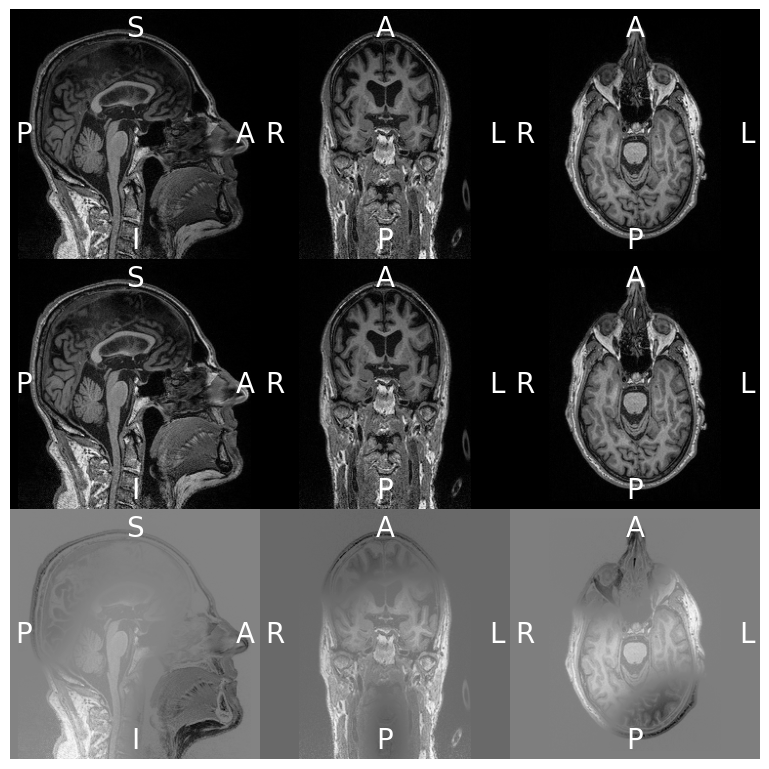

In [22]:
# Your answers to Step 2
# Performing bias correction
t1_img = ants.image_read(t1_img_name)
t1_n3 = ants.n3_bias_field_correction(t1_img)
t1_diff = t1_img - t1_n3
ants.plot_ortho_stack([t1_img,t1_n3,t1_diff])
write_image(t1_n3,rootdir=subject_root,subject=subject_id,image_type="anat",image_desc="t1-n3")
write_image(t1_diff,rootdir=subject_root,subject=subject_id,image_type="anat",image_desc="bias-field")

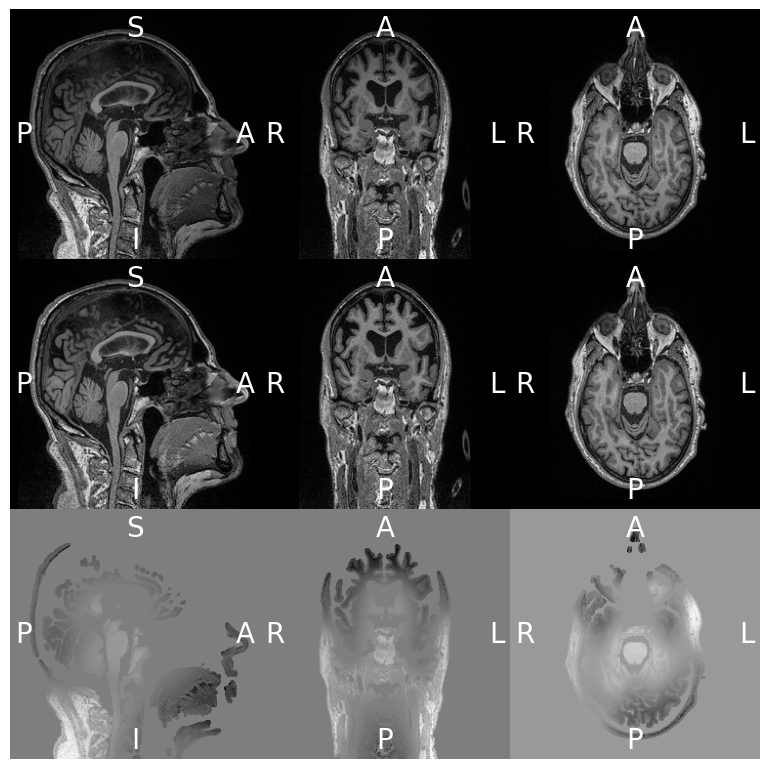

In [23]:
# Having a go with N4 algorithm instead
t1_img = ants.image_read(t1_img_name)
t1_n4 = ants.n4_bias_field_correction(t1_img)
t1_diff = t1_img - t1_n4
ants.plot_ortho_stack([t1_img,t1_n4,t1_diff])
write_image(t1_n4,rootdir=subject_root,subject=subject_id,image_type="anat",image_desc="t1-n4")
write_image(t1_diff,rootdir=subject_root,subject=subject_id,image_type="anat",image_desc="bias-field")

## Step 3 - Brain extraction
Produce a skull-stripped image from the bias corrected image. Make sure to do additional cleaning if you think it is necessary. What is the volume of the resulting mask?

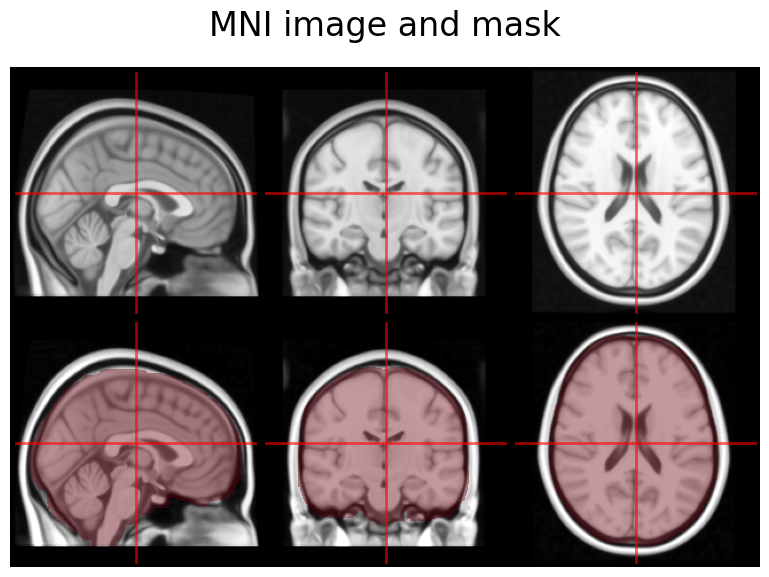

In [24]:
# Your answer to Step 3
# Creating a brain mask
atlasdir = os.path.join(data_root,"atlas")
mni_img_file = os.path.join(atlasdir,"MNI152_T1_1mm.nii.gz")
mni_img = ants.image_read(mni_img_file)
mni_mask_file = os.path.join(atlasdir,"MNI152_T1_1mm_brain_mask_dil.nii.gz")
mni_mask = ants.image_read(mni_mask_file)
ants.plot_ortho_double(image=mni_img, image2=mni_img,
                       overlay=mni_mask, overlay2=mni_mask, overlay_cmap2="Reds_r",
                       overlay_alpha=0.0, overlay_alpha2=0.4,title="MNI image and mask",title_dy=0.25)

In [25]:
init_tx_file = ants.affine_initializer(fixed_image = mni_img, moving_image = t1_n3, mask = mni_mask)
init_tx = ants.read_transform(init_tx_file)
t1_mni_init = ants.apply_transforms(fixed = mni_img, moving = t1_n3,transformlist=init_tx_file)

In [26]:
affine = ants.registration(fixed = mni_img, moving = t1_n3, type_of_transform = "Affine", initial_transform = init_tx_file, mask = mni_mask)

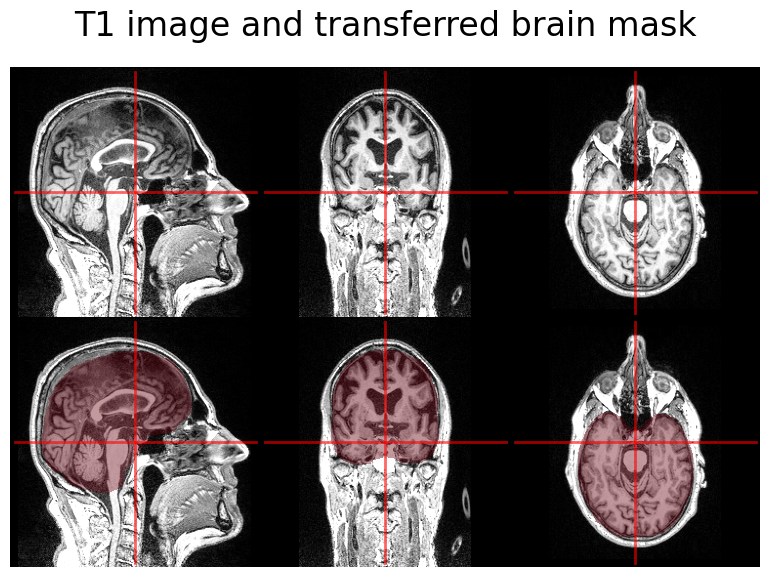

In [27]:
t1_mask = ants.apply_transforms(fixed = t1_n3, moving = mni_mask,transformlist=affine['fwdtransforms'],interpolator="nearestNeighbor",whichtoinvert=[True])
ants.plot_ortho_double(image=t1_n3, image2=t1_n3, scale=True,scale2=True,overlay=t1_mask, overlay2=t1_mask,overlay_cmap2="Reds_r",
                       overlay_alpha=0.0, overlay_alpha2=0.4,title="T1 image and transferred brain mask",title_dy=0.25)

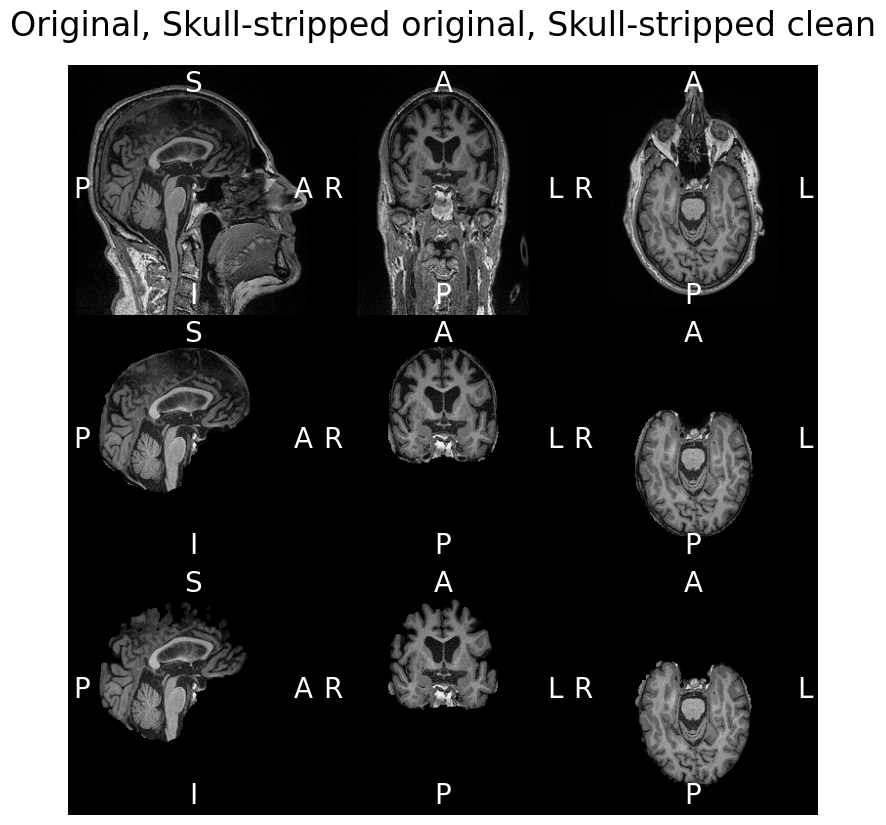

In [28]:
t1_brain = ants.mask_image(t1_n3,t1_mask)
t1_mask_cleaned = ants.get_mask(t1_brain,cleanup=3)
t1_brain_cleaned = ants.mask_image(t1_n3,t1_mask_cleaned)
ants.plot_ortho_stack([t1_n3,t1_brain,t1_brain_cleaned],title="Original, Skull-stripped original, Skull-stripped clean")

In [31]:
# Volume of resulting mask
brain_vol_stats = ants.label_stats(t1_brain_cleaned ['volume'])
print(brain_vol_stats)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Step 4 - Tissue segmentation
Perform tissue segmentation on the image. Is the GM volume in this subject more or less than the subject `011-S-4906`? Is it a greater or less percentage of the overall brain?

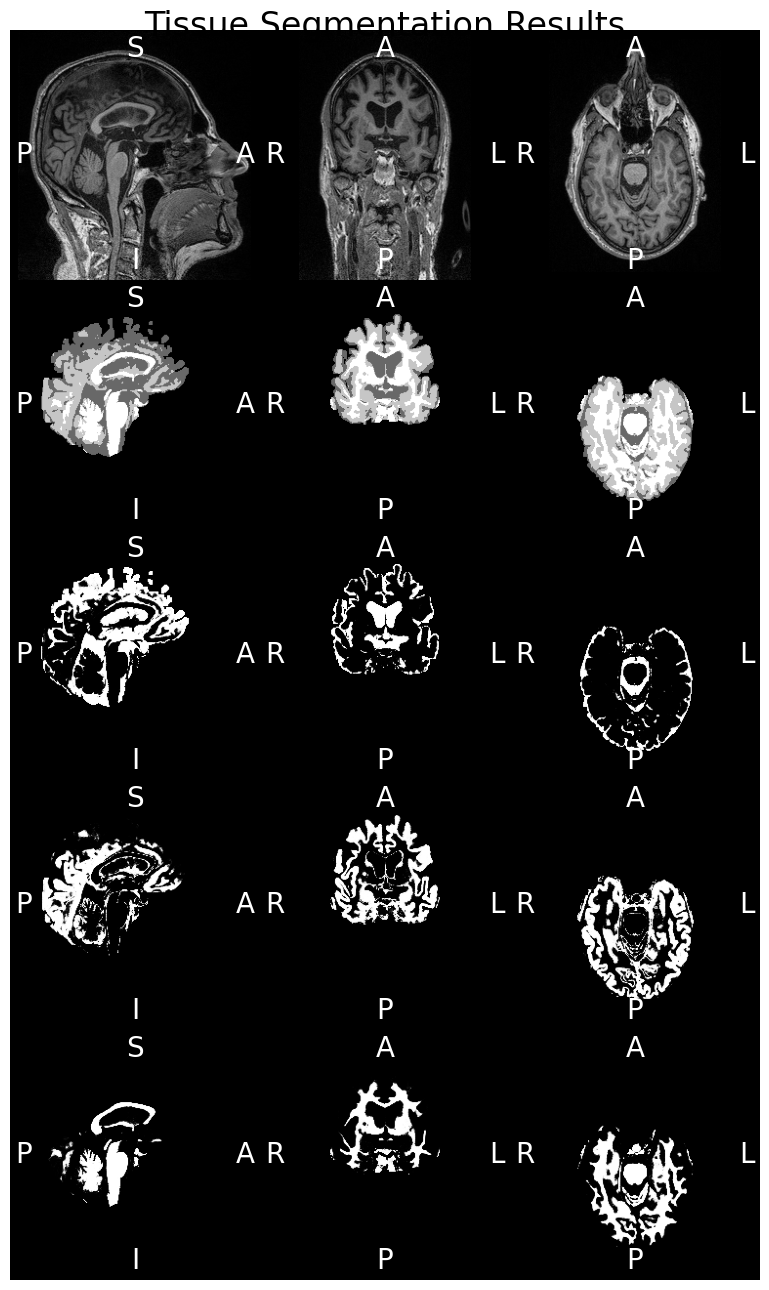

In [34]:
# Your answer to Step 4
# Below put your answer for creating a brain mask and extracting volumes out
tissue_seg = ants.atropos(a=t1_n3,x=t1_mask_cleaned,m="[0.3,1x1x1]", i='Kmeans[3]')
ants.plot_ortho_stack([t1_n3,tissue_seg['segmentation'],tissue_seg['probabilityimages'][0],
tissue_seg['probabilityimages'][1],tissue_seg['probabilityimages'][2]],title="Tissue Segmentation Results")
write_image(tissue_seg['segmentation'],rootdir=subject_root,
subject=subject_id,image_type="anat",image_desc="t1-bin-seg")


In [37]:
tissue_stats = ants.label_stats(t1_n3,tissue_seg['segmentation'],)
print(tissue_stats)

   LabelValue        Mean         Min         Max      Variance      Count  \
3         0.0   59.131693    0.000000  792.638306  10731.669228  9621430.0   
0         1.0   71.576849    0.000000  165.891891    764.830106   304252.0   
1         2.0  168.938895   68.781891  560.685059    933.141802   517185.0   
2         3.0  258.238328  151.278000  641.859985   1024.980036   370573.0   

         Volume          Mass         x          y         z    t  
3  1.284306e+07  0.000000e+00  0.000000   0.000000  0.000000  0.0  
0  4.061273e+05  2.177740e+07 -1.511419 -14.338455  4.106730  0.0  
1  6.903586e+05  8.737266e+07  0.752690 -10.415817  0.695282  0.0  
2  4.946552e+05  9.569615e+07  0.690372  -8.430461 -2.515436  0.0  


Grey matter in this brain is larger in volume than on the practice notebook

In [40]:
percent_GM1 = 6.90 / (4.95+6.90+4.06)*100 # Percentage of this brain which is grey matter
print (f"Percentage of this brain which is GM: {percent_GM1}")

Percentage of this brain which is GM: 43.368950345694536


In [41]:
percent_GM2 = 5.74 / (5.74+4.77+4.21)*100 # Percentage of example brain which is grey matter
print (f"Percentage of previous example brain which is GM: {percent_GM2}")

Percentage of previous example brain which is GM: 38.99456521739131


## Step 5 - Brain parcellation
One of you should run FreeSurfer on this subject. You should also transfer the AAL labels to this subject. Tell me what the volumes of the left and right precuneus are for both methods.

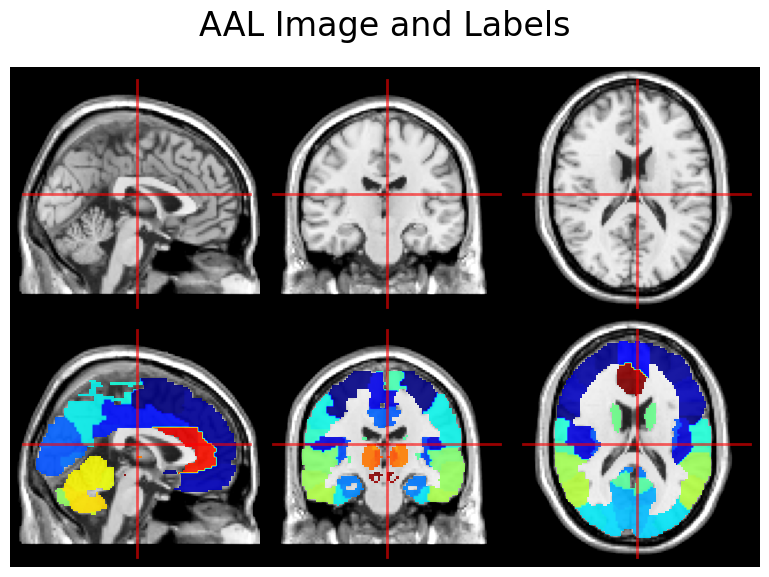

In [42]:
# Your answer to Step 5
# Creating a brain mask and extracting volumes out

aal_template_file = os.path.join(atlasdir,"AAL3v1_1mm.nii.gz")
aal_template = ants.image_read(aal_template_file).astype("uint32")
aal_img_file = os.path.join(atlasdir,"single_subj_T1.nii")
aal_img = ants.image_read(aal_img_file)
ants.plot_ortho_double(image=aal_img,image2=aal_img, scale=True,scale2=True, overlay=aal_template,overlay2=aal_template,
                      overlay_alpha=0.0,title="AAL Image and Labels",title_dy=0.25)

In [44]:
t1_mask_dil = ants.iMath(t1_mask_cleaned,'MD',2)
aal_affine_init_file = ants.affine_initializer(fixed_image = t1_n3,moving_image = aal_img)
syn_aal = ants.registration(fixed=t1_n3,moving=aal_img,mask=t1_mask_dil,
type_of_transform="SyN",initial_transform=aal_affine_init_file,
reg_iterations=(60,30,15))

 bad det -1 v 1 u -1
 bad det -1 v 1 u -1 new 1


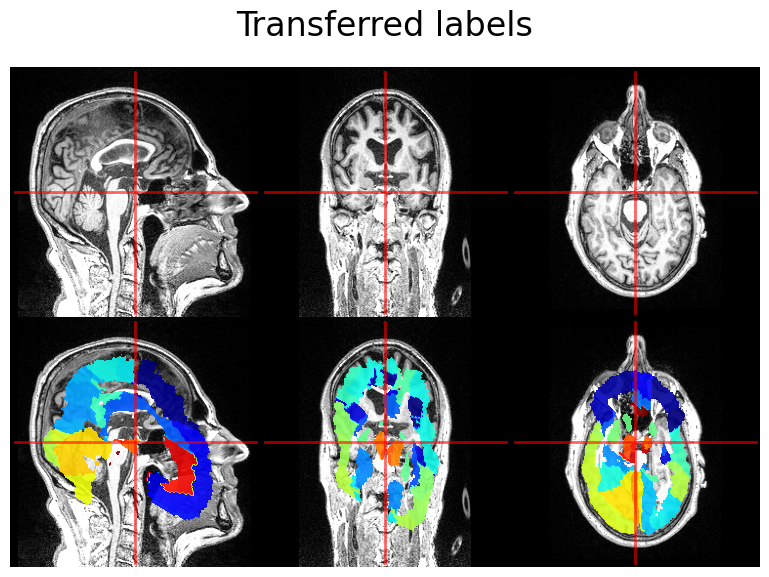

In [45]:
t1_aal_label = ants.apply_transforms(fixed = t1_n3, moving = aal_template,transformlist=syn_aal['fwdtransforms'],interpolator="genericLabel")
ants.plot_ortho_double(image=t1_n3,image2=t1_n3,overlay=t1_aal_label,overlay2=t1_aal_label,
                       scale=True,scale2=True,
                      overlay_alpha=0.0,title="Transferred labels",title_dy=0.25)
write_image(syn_aal['warpedmovout'], rootdir=subject_root,subject = subject_id, image_type="anat",
image_desc = "aal-resampled")
write_image(t1_aal_label, rootdir=subject_root,subject = subject_id, image_type="anat",
image_desc = "aal-labels")


In [46]:
aal_stats = ants.label_stats(t1_n3,t1_aal_label)
df_aal = pd.read_table(os.path.join(atlasdir,"AAL3v1_1mm.nii.txt"),
names=["LabelName","LabelValue"],delim_whitespace=True)
df_aal = df_aal.set_index("LabelValue")
aal_stats = aal_stats.set_index("LabelValue")
aal_stats = aal_stats.join(df_aal)
aal_stats = aal_stats[["LabelName","Volume","Mean","Min","Max","Variance"]]
print(aal_stats)

                  LabelName        Volume        Mean         Min         Max  \
LabelValue                                                                      
0.0                     NaN  1.255523e+07   57.058287    0.000000  792.638306   
1.0            Precentral_L  3.972614e+04  147.753444    0.000000  559.178894   
2.0            Precentral_R  3.867295e+04  155.981062    0.000000  369.905884   
3.0         Frontal_Sup_2_L  4.822772e+04  136.323533    0.000000  571.639709   
4.0         Frontal_Sup_2_R  6.034005e+04  110.744255    0.000000  575.656677   
...                     ...           ...         ...         ...         ...   
166.0               Red_N_R  5.312658e+02  218.309263   39.096764  348.143066   
167.0                  LC_L  2.669678e+01  217.569611  100.576324  313.037048   
168.0                  LC_R  2.402710e+01  181.211441   60.551498  342.369293   
169.0               Raphe_D  9.877807e+01  286.939748  252.345016  318.324432   
170.0               Raphe_M 

Tell me what the volumes of the left and right precuneus are for both methods.

## Step 6 - PET SUVR measurements
Finally, register the PET data with the MRI and give SUVR precuneus measures from both parcellations above using the cerebellum region as the reference. Is this person have higher or lower uptake than subject `011-S-4906`? What would the SUVR be if the reference region was the pons?

In [ ]:
# Your answer to Step 6
## SUVR = standardised uptake value ratio 
# Creating a brain mask and extracting volumes out

In [ ]:
bids_desc = "av45-adni-preproc"
av45_name = os.path.join(subject_root,"pet","sub-" + subject_id + "_desc-" + bids_desc + ".nii.gz")
av45 = ants.image_read(av45_name)
pet_to_mri = ants.registration(fixed = t1_fs_nu,moving=av45,type_of_transform="Rigid")
ants.plot_ortho_double(image=t1_fs_nu,image2=t1_fs_nu,overlay=t1_fs_nu,overlay_alpha=0.0,
                       overlay2=pet_to_mri['warpedmovout'], overlay_alpha2=0.55,
                       scale=True,scale2=True,title="Co-registered MRI and PET", title_dy=0.25)
fs_nu_in_pet = ants.apply_transforms(fixed=av45, moving=t1_fs_nu,whichtoinvert=[True],
transformlist=pet_to_mri['fwdtransforms'],interpolator="bSpline")
fs_aparc_in_pet = ants.apply_transforms(fixed=av45, moving=t1_fs_aparc,whichtoinvert=[True],
transformlist=pet_to_mri['fwdtransforms'],interpolator="genericLabel")